### load 資料集

In [5]:
from datasets import load_dataset
ds = load_dataset("jpwahle/machine-paraphrase-dataset")
print(ds['train'])

Dataset({
    features: ['text', 'label', 'dataset', 'method'],
    num_rows: 200767
})


In [3]:
from datasets import DatasetDict

train_test = ds['train'].train_test_split(test_size=0.2)
dataset = DatasetDict({
    'train': train_test['train'],
    'validation': train_test['test'],
    'test': ds['test']
})

### load Longformer model

In [2]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification

# 載入 Tokenizer 和模型
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained(
    'allenai/longformer-base-4096',
    num_labels=2  # 根據分類任務的類別數調整
)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### tokenize

In [2]:
def preprocess_function(examples):
    return tokenizer(
        examples['text'],  # 假設文字欄位是 'text'
        truncation=True,
        padding='max_length',
        max_length=512
    )

In [4]:
# 對 train 和 test 資料進行預處理
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 40154/40154 [00:21<00:00, 1861.77 examples/s]


### 先使用小部分資料測試訓練

In [5]:
tokenized_datasets['train'] = tokenized_datasets['train'].shuffle(seed=42).select(range(int(0.1 * len(tokenized_datasets['train']))))

In [6]:
tokenized_datasets['train'].shape

(16061, 6)

### device check

In [7]:
import torch
print(torch.cuda.is_available())  # True 表示 GPU 可用
print(torch.cuda.device_count())  # 返回可用 GPU 的數量
print(torch.cuda.get_device_name(0))  # 確認 GPU 的名稱

True
1
NVIDIA GeForce RTX 4060 Ti


### 訓練

In [8]:
from transformers import TrainingArguments, Trainer, AdamW

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=2e-5,
    save_total_limit=1,
    weight_decay=0.01,
    fp16=True
)

optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    betas=(0.9, 0.999),  # β1=0.9, β2=0.999
    eps=1e-8  # ǫ=1e-8
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    optimizers=(optimizer, None)
)

trainer.train()


c:\Topics\.venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Topics\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\sogo0\AppData\Local\Temp\ipykernel_29736\3459491548.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 20%|█▉        | 100/502 [04:48<19:12,  2.87s/it]

{'loss': 0.2007, 'grad_norm': 0.055410392582416534, 'learning_rate': 1.6294820717131476e-05, 'epoch': 0.2}


 40%|███▉      | 200/502 [09:32<14:31,  2.89s/it]

{'loss': 0.0117, 'grad_norm': 0.014957739971578121, 'learning_rate': 1.2310756972111555e-05, 'epoch': 0.4}


 60%|█████▉    | 300/502 [14:19<09:34,  2.85s/it]

{'loss': 0.0116, 'grad_norm': 0.0137145034968853, 'learning_rate': 8.326693227091634e-06, 'epoch': 0.6}


 80%|███████▉  | 400/502 [19:04<04:54,  2.89s/it]

{'loss': 0.0104, 'grad_norm': 0.008970087394118309, 'learning_rate': 4.382470119521913e-06, 'epoch': 0.8}


100%|█████████▉| 500/502 [23:51<00:05,  2.88s/it]

{'loss': 0.0032, 'grad_norm': 0.016456827521324158, 'learning_rate': 3.9840637450199207e-07, 'epoch': 1.0}


                                                 
100%|██████████| 502/502 [42:49<00:00,  2.82s/it]    

{'eval_loss': 0.02358310855925083, 'eval_runtime': 1130.5688, 'eval_samples_per_second': 35.517, 'eval_steps_per_second': 8.88, 'epoch': 1.0}


100%|██████████| 502/502 [42:50<00:00,  5.12s/it]

{'train_runtime': 2570.7225, 'train_samples_per_second': 6.248, 'train_steps_per_second': 0.195, 'train_loss': 0.04733373508213526, 'epoch': 1.0}


TrainOutput(global_step=502, training_loss=0.04733373508213526, metrics={'train_runtime': 2570.7225, 'train_samples_per_second': 6.248, 'train_steps_per_second': 0.195, 'total_flos': 5274846867339264.0, 'train_loss': 0.04733373508213526, 'epoch': 1.0})

### evaluate

In [9]:
results = trainer.evaluate()
print(results)

100%|██████████| 10039/10039 [18:33<00:00,  9.02it/s]

{'eval_loss': 0.02358310855925083, 'eval_runtime': 1113.2053, 'eval_samples_per_second': 36.071, 'eval_steps_per_second': 9.018, 'epoch': 1.0}


### 儲存模型 (有路徑)

In [28]:
model.save_pretrained('./test2/finetuned-longformer')
tokenizer.save_pretrained('./test2/finetuned-longformer')

('./test2/finetuned-longformer\\tokenizer_config.json',
 './test2/finetuned-longformer\\special_tokens_map.json',
 './test2/finetuned-longformer\\vocab.json',
 './test2/finetuned-longformer\\merges.txt',
 './test2/finetuned-longformer\\added_tokens.json')

### load 模型做測試 (有路徑)

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 加載模型
model = AutoModelForSequenceClassification.from_pretrained('./test2/finetuned-longformer')

# 加載分詞器
tokenizer = AutoTokenizer.from_pretrained('./test2/finetuned-longformer')

c:\Topics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from datasets import load_dataset
ds = load_dataset("jpwahle/machine-paraphrase-dataset")

In [8]:
def preprocess_function(examples):
    return tokenizer(
        examples['text'],  # 假設文字欄位是 'text'
        truncation=True,
        padding='max_length',
        max_length=512
    )

### tokenize test data

In [9]:
tokenized_datasets = ds['test'].map(preprocess_function, batched=True)

### 裁切想測試的內容

In [10]:
wiki_data = tokenized_datasets.filter(lambda x: x['dataset'] == 'arxiv' and x['method'] == 'spinnerchief')

Filter: 100%|██████████| 384291/384291 [01:11<00:00, 5384.57 examples/s]


In [11]:
wiki_data.shape

(85322, 6)

In [12]:
sampled_wiki_data = wiki_data.shuffle(seed=42).select(range(int(0.001 * len(wiki_data))))

In [13]:
sampled_wiki_data.shape

(85, 6)

### 處理成torch dataloader做測試

In [14]:
from torch.utils.data import DataLoader
import torch

# 移除不需要的列（如 'text', 'dataset', 'method' 等）
filtered_dataset = sampled_wiki_data.remove_columns(['text', 'dataset', 'method'])

# 創建 DataLoader
test_dataloader = DataLoader(filtered_dataset, batch_size=8, collate_fn=lambda x: {k: torch.tensor([d[k] for d in x]) for k in x[0]})

In [15]:
from tqdm import tqdm 

model.eval()
all_preds = []
all_labels = []

for batch in tqdm(test_dataloader, desc="Testing", unit="batch"):
    with torch.no_grad():
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        preds = outputs.logits.argmax(dim=-1)
    
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(batch['label'].cpu().numpy())

Testing: 100%|██████████| 11/11 [00:36<00:00,  3.27s/batch]


### 測試結果

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")
print(f"f1 score: {f1}")

Test Accuracy: 0.788235294117647
f1 score: 0.775


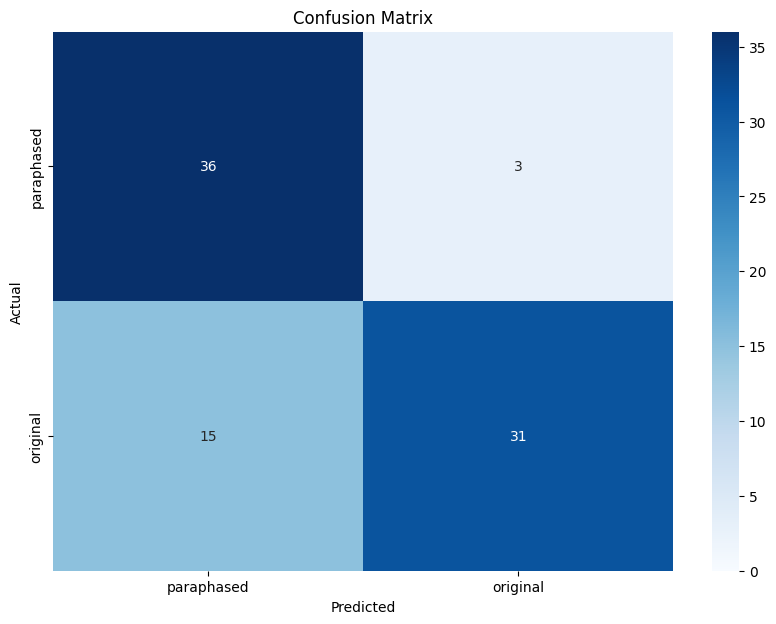

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['paraphased', 'original']


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()